##  Contexto general a analizar
Cornershop es una empresa global que entrega miles de pedidos todos los días en varias ciudades y países.

***Objetivo principal:***
Genere un modelo de Machine Learning que identifique la duración total (total_minutes) de un pedido en función de la información de tiendas, pedidos, compradores y sucursales.

## 1.- Importando Datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from haversine import haversine 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from shapely.geometry import Point , Polygon
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from pyproj import Proj, transform
import folium as folium
from folium import plugins
from folium.plugins import HeatMap

## 2.- Importando Datasets

El objetivo de importar los datos es generar un dataset consolidado que sirva para poder generar el modelo que entregue el mejor desempeño para el calculo del "tiempo_esperado", la variable donde con la cual se hará match de será order_id, se analizarán tambien formato y completitud de los datos

### 2.1- Importando Tabla Orders

In [2]:
# Generando un tabla Orders
orders = pd.read_csv('input\orders.csv', sep=',')
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [3]:
print("Q de columnas: ", orders.shape[1])
print("Q de filas: ", orders.shape[0])
print("Q distintos de Order id: ",orders.order_id.nunique())
print("Q distintos de Shopper id: ",orders.shopper_id.nunique())
print("Q distintos de Store Branch id: ",orders.store_branch_id.nunique())

Q de columnas:  8
Q de filas:  10000
Q distintos de Order id:  10000
Q distintos de Shopper id:  2864
Q distintos de Store Branch id:  476


En el dataset contamos con 1000 filas, 8 columnas, 2864 shopers ids y solamente 476 store_branch_id

In [4]:
# Cuantos valores son missing en variable de total_minutes?
orders.total_minutes.notnull().sum()

8000

In [5]:
# Cuantos descripción de 
orders.total_minutes.describe()

count    8000.000000
mean       81.106130
std        34.720837
min        11.969489
25%        55.225480
50%        74.731672
75%       100.273498
max       304.190303
Name: total_minutes, dtype: float64

In [6]:
orders.total_minutes.describe()

count    8000.000000
mean       81.106130
std        34.720837
min        11.969489
25%        55.225480
50%        74.731672
75%       100.273498
max       304.190303
Name: total_minutes, dtype: float64

In [7]:
orders['timestamp'] = orders['promised_time'].apply(lambda x: pd.to_datetime(x.split('+')[0]))
orders['dia'] = orders['timestamp'].apply(lambda x: x.weekday())
orders['hora'] = orders['timestamp'].apply(lambda x: x.hour)
orders['viernes'] = np.where(orders['timestamp'].apply(lambda x: x.weekday()) == 4, 1, 0) # se crea variable si la orden fue generada un viernes
orders['sabado'] = np.where(orders['timestamp'].apply(lambda x: x.weekday()) == 5, 1, 0) # se crea variable si la orden fue generada un sabado
orders['domingo'] = np.where(orders['timestamp'].apply(lambda x: x.weekday()) == 6, 1, 0) 
orders['horario_am'] = np.where(orders['timestamp'].apply(lambda x: x.hour) <= 12, 1, 0) # se crea variable si la orden fue en horario AM
orders['horario_pm'] = np.where(orders['timestamp'].apply(lambda x: x.hour) >12, 1, 0)   # se crea variable si la orden fue en horario AM
orders.dia.describe()


count    10000.000000
mean         4.709000
std          0.454466
min          4.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          6.000000
Name: dia, dtype: float64

Se genera una nueva variable dummy que calcula el ratio entre si la entrega fue hecha un día viernes (para este valor asignamos el valor 4 según la función weekday), por otro lado para la entregas realizadas el día sabado asignnamos el valor 5 según la función weekday, el ratio calcula la división entre el numero asignado para el día y total de minutos. 

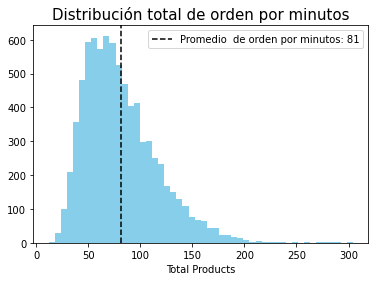

In [8]:
##Distribución total de minutos de tabla Order
orders.total_minutes.hist(grid=False, bins=50, color = "skyblue")
plt.axvline(orders.total_minutes.mean(), color='k', ls='--', linestyle='dashed',
            label='Promedio  de orden por minutos: {0}'.format(round(orders.total_minutes.mean()), 2))
plt.xlabel("Total Products")
plt.title("Distribución total de orden por minutos",fontsize=15)
plt.legend()

In [9]:
orders.total_minutes=orders.total_minutes.fillna(orders.total_minutes.median()).astype(int)

La variable de "total_minutes" se imputará por la mediana debido a que un 80% de los datos son nulos, se elige esta medida de tendencia central porque la distribución de esta variables no corresponde la distribución normal y "total_minutes" se usará para calcular ratio entre el dia de la semana que fue hecha la entrega y la cantidad de minutos de entrega.

**NOTA:** La variable total_minutes no se utilizará para modelar por la razón que es la variable que se va a predecir según solicitud de problema

Analizando el gráfico de histograma nos evidencia que la mayoria de las ordenes tienen en promedio menos de 100 minutos en ser completadas

False    0.5453
True     0.4547
Name: on_demand, dtype: float64

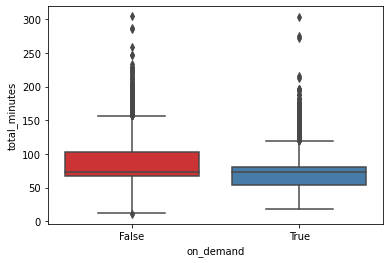

In [10]:
# Cuantos valores son missing en variable de total_minutes?
sns.boxplot(x="on_demand", y=orders.total_minutes, data=orders,palette="Set1")
orders.on_demand.value_counts('%')

El gráfico anterior nos muestra diferencias entre la mediana del total de minutos corresponde a aproximadamente a 80 mins en caso que la orden no fue entregada en menos de X minutos, pero sin embargo en caso que la orden si fue entregada en menos de x minutos la medaiana corresponde aproximadamente a 60 minutos.

El q de pedidos entregados con respecto al tiempo estimado o prometido ha sido de **45,4%** considerado cómo 'on time', dejando con un **54,6%** aquellos pedidos que por razón que se desconoce se entregaron posteriormente al tiempo comprometido por Cornershop.

### 2.2- Importando Tabla orders_products

In [11]:
# Generando un tabla Order_products
order_products = pd.read_csv('input\order_products.csv', sep=',')
order_products.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


En este caso no tenemos la equivalencia a cuantas unidades de un determiminado producto corresponden a un kilogramo y no poseemos información de la dimensión de cada una de las porciones

Adiocionalmente a lo anterior cómo los datos de la variable "buy_unit" no se ajustan a una distribución normal se utilizará la mediana para poder imputar esta variable.

In [12]:
print("Q de columnas: ", order_products.shape[1])
print("Q de filas: ", order_products.shape[0])
print("Q distintos de Order id: ",order_products.order_id.nunique())
print("Q distintos de Product id: ",order_products.product_id.nunique())
print ("Q de valores nulos: ",order_products.isnull().any())

Q de columnas:  4
Q de filas:  198500
Q distintos de Order id:  9978
Q distintos de Product id:  15422
Q de valores nulos:  order_id      False
product_id    False
quantity      False
buy_unit      False
dtype: bool


En total este dataset cuenta con 4 columnas y 198500 filas , no existen valores nulos, en total son 9978 ordenes distintas y 15422 productos distintos

In [13]:
order_products[order_products.buy_unit=='UN'].quantity.describe()

count    180654.000000
mean          1.908333
std           1.964279
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         100.000000
Name: quantity, dtype: float64

In [14]:
order_products[order_products.buy_unit=='KG'].quantity.describe()

count    17846.000000
mean         0.971702
std          0.728834
min          0.055000
25%          0.498000
50%          0.835000
75%          1.200000
max         16.250000
Name: quantity, dtype: float64

In [15]:
#imputacion de mediana
p_median = order_products.groupby('product_id').quantity.median() #corresponde a product_median
order_products = pd.merge(order_products, p_median, on='product_id', how='left', suffixes=('', '_median'))
order_products['q_converted'] = order_products.apply(lambda row: (row.quantity/row.quantity_median) if row.buy_unit=='KG' else row.quantity, axis=1)
order_products = order_products.groupby('order_id').sum()
order_products.head()

,quantity,quantity_median,q_converted
order_id,,,
0004a3841c1eeb6c6e77585a941c21e0,8.000,4.000,8.000000
0005a6ecbbde1e8d273f5577bcff2c9c,2.000,1.500,2.000000
0007baeb6700fc203be2d1f1e11222d7,39.000,32.500,39.000000
0012195a6a8ca9ec308a3010eeea8ebc,13.000,13.000,13.000000
0013011fa72b498b9feb84f4e7104980,64.636,64.298,65.338677


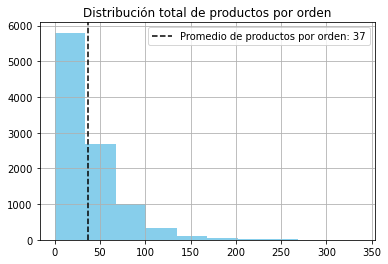

In [16]:
order_products['q_converted'].hist(grid=True,color = "skyblue")
plt.axvline(order_products['q_converted'].mean(), color='k', ls='--', linestyle='dashed',
            label='Promedio de productos por orden: {0}'.format(round(order_products['q_converted'].mean()), 2))
plt.title('Distribución total de productos por orden')
plt.legend()

En base al nuevo atributo generado "q_converted" podemos inferir que a gran mayoria de los productos corresponden a menos de 2 unidades vendidas por Cornershop.

### 2.3- Importando Tabla Shoppers 

In [17]:
# Import shoppers dataset
shoppers = pd.read_csv('input/shoppers.csv', sep=',')
shoppers.shape

(2864, 6)

In [18]:
# Calulando los valores missings de Tabla Shoppers
total = shoppers.isnull().sum().sort_values(ascending=False)
percent = round((shoppers.isnull().sum() / shoppers.isnull().count() * 100), 2)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent(%)'])
missing_values

,Total,Percent(%)
found_rate,101,3.53
rating,84,2.93
accepted_rate,27,0.94
shopper_id,0,0.00
seniority,0,0.00
picking_speed,0,0.00


In [19]:
shoppers['seniority'].value_counts()

6c90661e6d2c7579f5ce337c3391dbb9    1643
50e13ee63f086c2fe84229348bc91b5b     719
41dc7c9e385c4d2b6c1f7836973951bf     440
bb29b8d0d196b5db5a5350e5e3ae2b1f      62
Name: seniority, dtype: int64

In [20]:
shoppers.describe()

,found_rate,picking_speed,accepted_rate,rating
count,2763.000000,2864.000000,2837.000000,2780.000000
mean,0.861082,1.762392,0.908276,4.848428
std,0.031038,0.665962,0.107911,0.133011
min,0.737300,0.650000,0.240000,3.880000
25%,0.842900,1.290000,0.880000,4.800000
50%,0.863900,1.580000,0.944444,4.880000
75%,0.881950,2.120000,1.000000,4.960000
max,0.971000,7.040000,1.000000,5.000000


### 2.4- Importando Tabla de Tiendas

In [21]:
store = pd.read_csv('input/storebranch.csv', sep=',')
store.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


La tabla de Branches (tiendas) es muy importante porque con la latitud y longitud de la misma, podremos construir la nueva variable de distancia

In [22]:
store.rename(columns=({'lat':'store_lat', 'lng':'store_lng'}), inplace=True)

## 3.- Consolidación de data 

El objetivo de poder construir una tabla consolidada es que sirva para el desarrollo del modelo predictivo 

In [23]:
# join entre orders and order products
df = pd.merge(orders, order_products, on='order_id')
# join con shoppers data
df = pd.merge(df, shoppers, on='shopper_id')
# join con branch data
df = pd.merge(df, store,on='store_branch_id')
df.shape

(9978, 27)

## 4.- Pre Procesamiento de la data

In [24]:
#construcción de nuevas variables con data consolidada
df['q_ordenes_x_shopper'] = df['order_id'].groupby(df['shopper_id']).transform('count')

Se construyó nueva variable *** q_ordenes_x_shopper ***  que corresponde a la cantidad de ordenes adquiridas por cada shopper (podría ser una variable que sea predictora)

In [25]:
#Se modifica en formato de variablespara que quede en formato int32
df['on_demand'] = np.where(df['on_demand']==True,1,0).astype('int32')
df['total_minutes'] = df['total_minutes'].astype('int32')
df['dia'] = df['dia'].astype('int32')
df['hora'] = df['hora'].astype('int32')

### 4.1 Calculando la distancia entre la tienda o sucursal y el cliente


El objetivo es crear una nueva variable que calcule la distancia entre la dirección de la orden del cliente y la dirección de la tienda store, el propósito de la construcción de esta nueva variable es incorporarla dentro de las variables dependientes dentro del modelo de Machine Learning

**FUENTE : ** https://pypi.org/project/haversine/

In [26]:
df['destino'] = df[['lat', 'lng']].apply(tuple, axis=1)
df['origen'] = df[['store_lat', 'store_lng']].apply(tuple, axis=1)

In [27]:
df['distancia'] = df.apply(lambda x: haversine(x.origen, x.destino), axis=1)
df.shape

(9978, 31)

(0.0, 318.65)

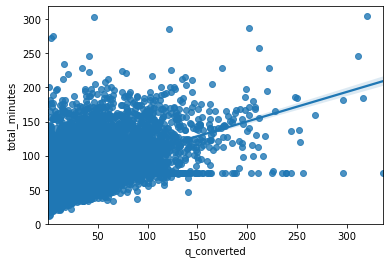

In [28]:
sns.regplot(x="q_converted", y="total_minutes", data=df)
plt.ylim(0,)

Esta grafica nos muestra que, se puede apreciar como la relación entre ambos atributos tiende a una regresión lineal mucho más marcada, se evidencia que a medida que son más productos comprados la cantidad total de minutos por despacho de orden aumenta, corresponderia a una relación directamente proporcional

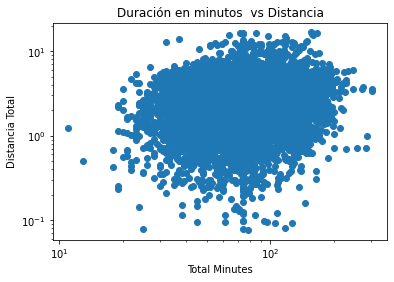

In [29]:
plt.scatter(df.total_minutes, df.distancia)
plt.xlabel('Total Minutes')
plt.ylabel('Distancia Total')
plt.yscale('log')
plt.xscale('log')
plt.title('Duración en minutos  vs Distancia')
plt.show()

### 4.2. Visualizando latitud y longitud de cada Store 

El objetivo de este mapa es poder visualizar donde se encuentran cada uno de las coordenadas del origen de los pedidos de cada cliente y las coordenadas de cada una de las tiendas donde el pedido fue despachado en función de la distancia entre la dirección del cliente y la tienda, se utiliza la libreria folium que permite visualizar los mapas tipo Leaflet 

**FUENTE :** https://python-visualization.github.io/folium/

#### 4.2.1 Visualización entre distancia y tienda

In [30]:
#Visualizamos un 10% de las observaciones
map = folium.Map(location=[df.store_lat.mean(), df.store_lng.mean()], zoom_start=12, control_scale=True)
# crear capa de mapa de calor
heatmap = HeatMap( list(zip(df["store_lat"], df["store_lng"], df['distancia'])),
                   min_opacity=0.4,
                   radius=50, blur=50, 
                   max_zoom=1)
# añadir capa de mapa de calor al mapa base
heatmap.add_to(map)
map
    

lo que nos grafica esta imagen es nivel de **coordenadas de tienda** se visualiza que la gran mayoria de los pedidos se encuentran localizados en la región metropolitana, especificamente en el sector oriente, donde la distancia mayor con la tienda  se encuentra en el limite entre Vitacura y Las Condes, existe una parte importante tambien de concentración de tiendas a donde los clientes efectuaron sus pedidos ubicados en Santiago Centro

#### 4.2.2 Visualización entre distancia y destino cliente

In [31]:
#Visualizamos un 10% de las observaciones
map = folium.Map(location=[df.lat.mean(), df.lng.mean()], zoom_start=12, control_scale=True)
# crear capa de mapa de calor
heatmap = HeatMap( list(zip(df["lat"], df["lng"], df['distancia'])),
                   min_opacity=0.4,
                   radius=50, blur=50, 
                   max_zoom=1)
# añadir capa de mapa de calor al mapa base
heatmap.add_to(map)
map 

lo que nos grafica esta imagen es nivel de **coordenadas de cliente** se visualiza que la gran mayoria de los pedidos se encuentran localizados en la región metropolitana, especificamente en el sector oriente, a diferencia de la imagen anterior la dirección de los clientes, se encuentran mayormente ubicadas en los limites de las comunas de Providencia con Las Condes

In [32]:
## Eliminacion de variables que no se usarán para modelar con dataset que ya está consolidado (previo a correlación entre variables)
df.dtypes
df = df.drop(columns=['lat', 'lng', 'shopper_id', 'promised_time','timestamp', 'store_branch_id','store_id','store_lat','store_lng','destino','origen'])
df

,order_id,on_demand,total_minutes,dia,hora,viernes,sabado,domingo,horario_am,horario_pm,quantity,quantity_median,q_converted,seniority,found_rate,picking_speed,accepted_rate,rating,q_ordenes_x_shopper,distancia
0,e750294655c2c7c34d83cc3181c09de4,1,67,4,20,1,0,0,0,1,18.756,22.978,19.350000,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.920000,4.76,2,1.823027
1,3bb5d9adb3ecac1925b60d5d26a510c4,1,160,5,16,0,1,0,0,1,65.900,46.250,68.666667,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.920000,4.76,2,0.961906
2,b838eea64cf24dde0a78ce1feb84ca7c,0,122,5,16,0,1,0,0,1,156.000,104.000,156.000000,6c90661e6d2c7579f5ce337c3391dbb9,0.8909,1.17,0.960000,5.00,3,1.652017
3,2c85303190a77493348b0b827232f4d6,0,133,5,19,0,1,0,0,1,122.646,124.658,124.183333,6c90661e6d2c7579f5ce337c3391dbb9,0.8462,1.11,0.960000,4.96,4,0.694902
4,e606cc26b843c312df82a29d1f8d4372,0,94,5,0,0,1,0,1,0,99.216,64.500,99.800000,50e13ee63f086c2fe84229348bc91b5b,0.8138,1.89,0.840000,4.68,9,3.316288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9973,b1462a91b7fdedc7f6f6c117793d85c1,1,38,4,19,1,0,0,0,1,1.000,1.000,1.000000,50e13ee63f086c2fe84229348bc91b5b,0.7882,2.14,0.840000,4.80,1,1.037555
9974,6d2171d54c21240db2ba5200bccb1807,1,74,4,22,1,0,0,0,1,1.000,1.000,1.000000,bb29b8d0d196b5db5a5350e5e3ae2b1f,NaN,2.19,1.000000,4.20,1,3.569686
9975,820cd6e4d4667ba2ef042641c5cae926,1,84,4,20,1,0,0,0,1,1.000,1.000,1.000000,50e13ee63f086c2fe84229348bc91b5b,0.8521,2.49,0.826087,4.82,1,6.572974
9976,cd4b29e7f720a9dba4c99777c8f87b20,1,74,4,20,1,0,0,0,1,1.000,1.000,1.000000,50e13ee63f086c2fe84229348bc91b5b,0.8203,2.00,0.760000,4.84,1,3.724377


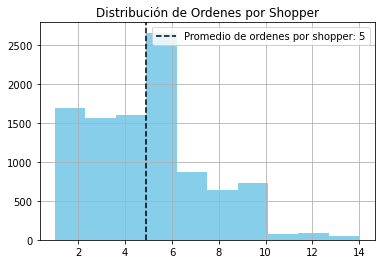

In [33]:
df['q_ordenes_x_shopper'].hist(grid=True,color = "skyblue")
plt.axvline(df['q_ordenes_x_shopper'].mean(), color='k', ls='--', linestyle='dashed',
            label='Promedio de ordenes por shopper: {0}'.format(round(df['q_ordenes_x_shopper'].mean()), 2))
plt.title('Distribución de Ordenes por Shopper')
plt.legend()

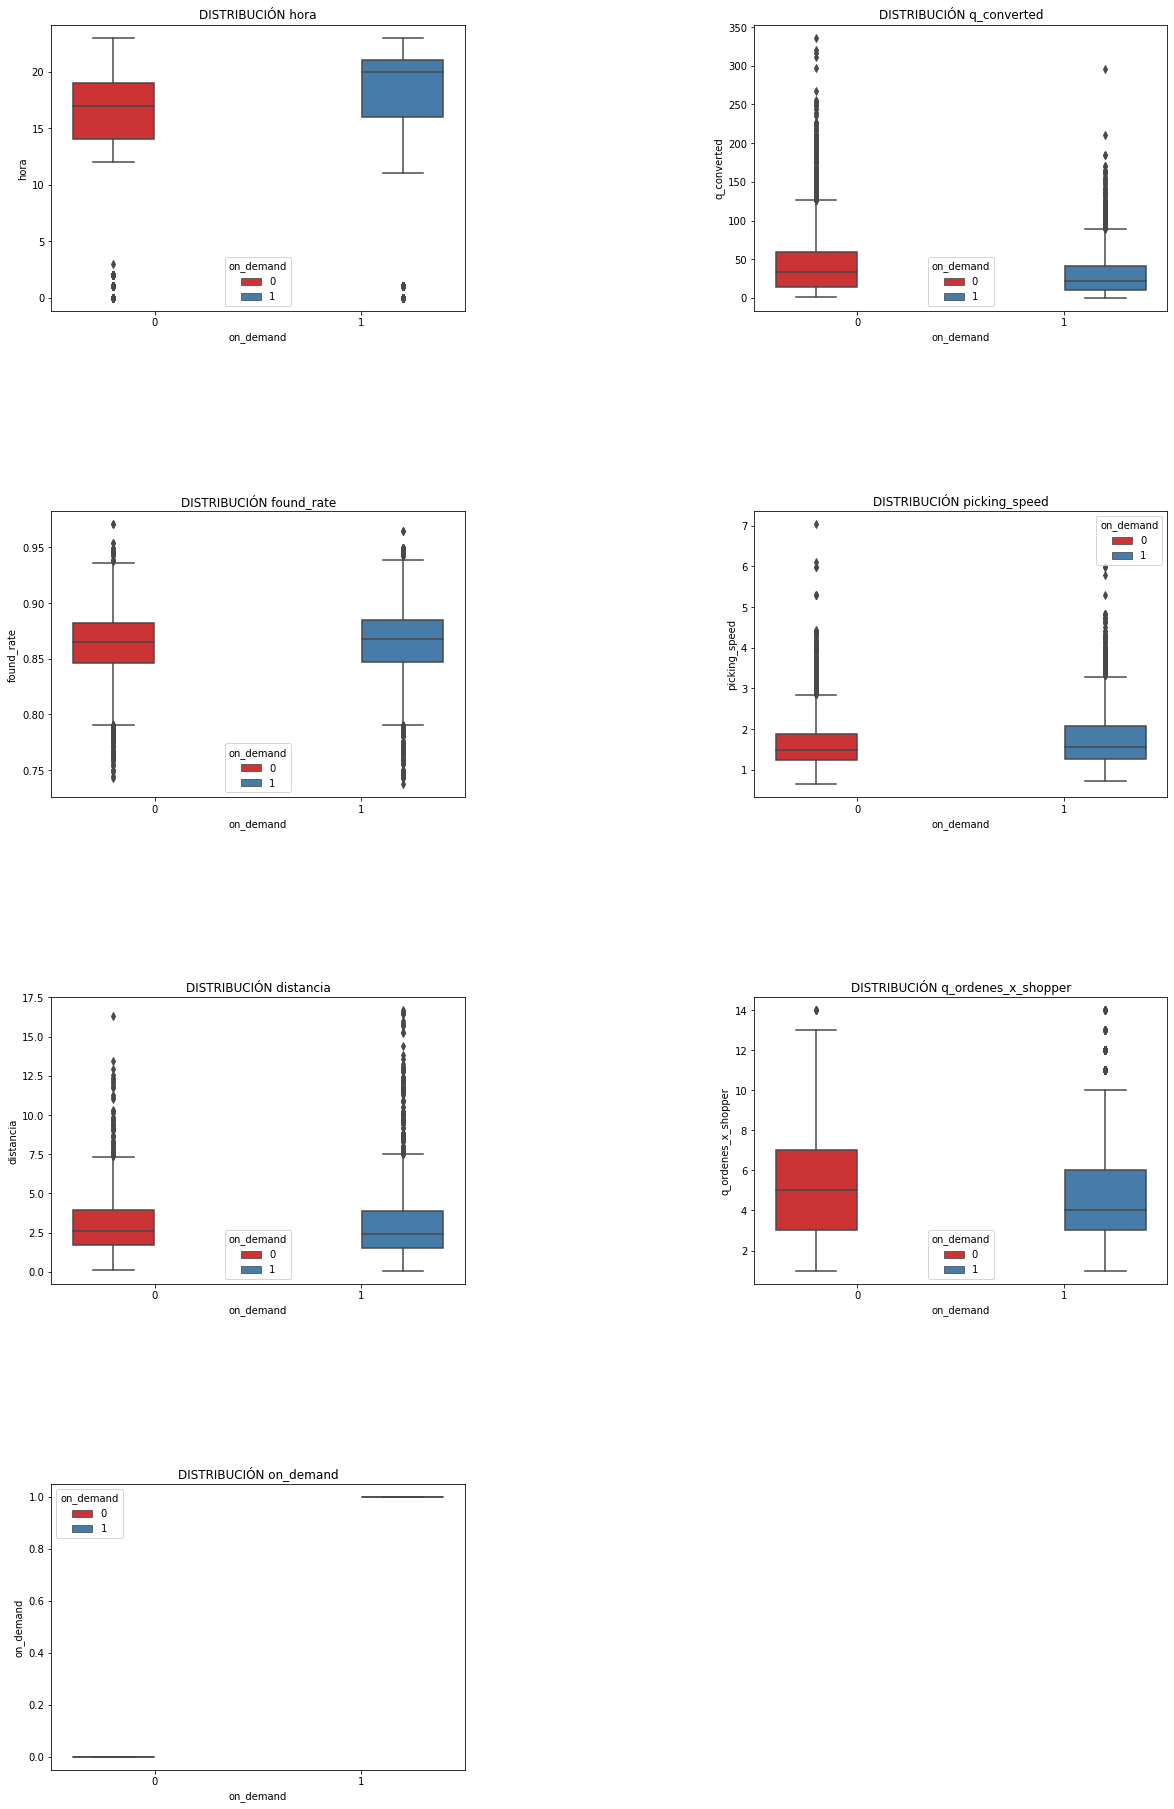

In [34]:
tipos=df[["hora","q_converted"
     ,"found_rate","picking_speed","distancia","q_ordenes_x_shopper","on_demand"]]
target_0 = df.loc[df['on_demand'] == 0]
target_1 = df.loc[df['on_demand'] == 1]
fig = plt.figure(figsize=(20,50))
a = 6 # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
for col in tipos:    
    plt.subplot(a, b, c)
    sns.boxplot(x="on_demand", y=col, data=tipos, hue="on_demand", palette="Set1")
    plt.title('DISTRIBUCIÓN {}' .format(col, a, b, c), fontsize=12)   
    plt.xlabel("on_demand")
    fig.subplots_adjust(wspace=0.7, hspace=0.7)
    c = c + 1

### 4.3 Matriz de correlaciones

In [35]:
tipos=df[["on_demand","hora","sabado","domingo","horario_am","q_converted"
     ,"found_rate","picking_speed","accepted_rate","seniority","q_ordenes_x_shopper","distancia"]]

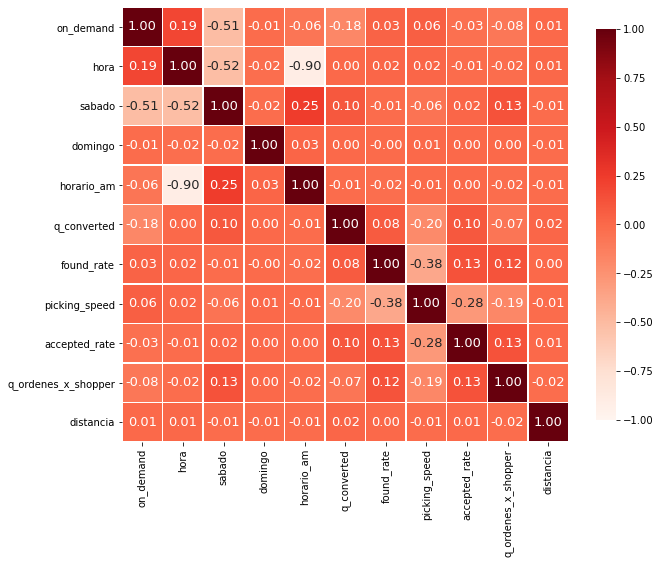

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
df_corr = tipos.corr()
ax = sns.heatmap(df_corr, linewidths=.5, annot_kws={"size": 13}, annot=True, fmt=".2f", cmap='Reds',
           vmin=-1, vmax=1, cbar_kws={"shrink": .9})

Lo que nos muestra el grafico anterior es que existe una baja correlación entre las variables que vamos a utilizar para modelar, lo cual es un buen indicador que las variable que estamos seleccionando no las estamos considerando 2 veces ( esto produciria un error en el modelamiento) 

### 4.4 Imputación de valores faltantes

In [37]:
# Create variable with average
found_rate = df["found_rate"].astype("float").median(axis=0)
accepted_rate=df["accepted_rate"].astype("float").median(axis=0)
rating_rate=df["rating"].astype("float").median(axis=0)

In [38]:
# Replace nan values with mean
df["found_rate"].replace(np.nan, found_rate, inplace=True)
df["accepted_rate"].replace(np.nan, accepted_rate, inplace=True)
df["rating"].replace(np.nan, rating_rate, inplace=True)

Para poder modelar no podemos tener valores missing en las variables, por lo tanto se seleccionó imputar por la mediana (ninguno de estos atributos tiene distribución normal, por eso se eligió esta medida de tendencia central) las variables de found_rate, accepted_rate y rating_rate. Este proceso se realiza antes del proceso de modelamiento

In [39]:
df.describe()

,on_demand,total_minutes,dia,hora,viernes,sabado,domingo,horario_am,horario_pm,quantity,quantity_median,q_converted,found_rate,picking_speed,accepted_rate,rating,q_ordenes_x_shopper,distancia
count,9978.00000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000
mean,0.45460,79.319302,4.709361,15.975246,0.290740,0.709160,0.000100,0.131790,0.868210,36.288735,30.302092,36.577706,0.863371,1.686459,0.917212,4.849840,4.896172,2.891952
std,0.49796,31.152647,0.454301,6.476184,0.454126,0.454173,0.010011,0.338279,0.338279,34.250712,27.250608,34.437267,0.029494,0.626140,0.096914,0.127743,2.489397,1.833710
min,0.00000,11.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.300000,0.153846,0.737300,0.650000,0.240000,3.880000,1.000000,0.076491
25%,0.00000,60.000000,4.000000,15.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000,10.000000,12.000000,0.846800,1.260000,0.880000,4.800000,3.000000,1.594564
50%,0.00000,74.000000,5.000000,18.000000,0.000000,1.000000,0.000000,0.000000,1.000000,27.155500,23.062500,27.588333,0.866000,1.510000,0.960000,4.880000,5.000000,2.505393
75%,1.00000,93.000000,5.000000,20.000000,1.000000,1.000000,0.000000,0.000000,1.000000,50.430000,42.738000,51.000000,0.883100,2.000000,1.000000,4.960000,6.000000,3.925637
max,1.00000,304.000000,6.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,335.400000,236.262000,336.333333,0.971000,7.040000,1.000000,5.000000,14.000000,16.672794


Se visualiza  que no hay missing values, lo cual es importante a la hora de entrenar los modelos de ML.

## 5. Modelamiento predictivo

El modelamiento predictivo se divide en:

 **A)** Se construirán los conjuntos de datos para entrenar los modelos, dichos set de datos corresponden a Entrenamiento y Testeo, el objetivo principal es la obtención de las mejores métricas de predicción con esta metodología.
 
 **B)** Se ajustarán cada uno de los modelos propuestos. 

Dichos modelos fueron elegidos porque en general tienen buen rendimiento cuando se desea predecir una variable continua, en este caso "total_minutes".
Los algoritmos predictivos a utilizar son:

* Multiple linear regression

* Random Forest Classifier

* Gradient Boosted Classifier

* Support Vector Machine


Las métricas a usar van a ser MAE y RMSE que corresponden al tipo de métrica que se utiliza frecuentemente para cuantificar el desempeño y resultado de los modelos a implementar.

### 5.1 Separación de data en Entrenamiento y Test

In [40]:
# Splitting data in training and test
from sklearn.model_selection import train_test_split
X_0 = df[["on_demand","hora","sabado","q_converted"
     ,"found_rate","picking_speed","accepted_rate","q_ordenes_x_shopper","horario_pm","order_id","distancia"]] # se elimina variables que no se usarán en modelo
Y_0 = df['total_minutes']

x_train, x_test, y_train, y_test= train_test_split(X_0, Y_0, test_size=.20, random_state=123)

print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', x_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (7982, 11)
Training Labels Shape: (1996, 11)
Testing Features Shape: (7982,)
Testing Labels Shape: (1996,)


In [41]:
# Scaling the data
sc_x=StandardScaler()
x_train1=x_train.drop(columns=['order_id'])
x_test1=x_test.drop(columns=['order_id'])
x_train1=sc_x.fit_transform(x_train1)
x_test1=sc_x.fit_transform(x_test1)

In [42]:
x_train1

array([[ 1.09107747,  0.62359407, -1.5631653 , ...,  0.84433643,
         0.39175019,  1.0374975 ],
       [-0.9165252 ,  0.62359407,  0.63972761, ...,  0.84433643,
         0.39175019, -1.09840952],
       [-0.9165252 ,  0.62359407, -1.5631653 , ..., -1.16134579,
         0.39175019, -0.86618346],
       ...,
       [-0.9165252 , -0.30053772,  0.63972761, ..., -0.3590729 ,
         0.39175019,  0.79097995],
       [ 1.09107747,  0.4695721 ,  0.63972761, ...,  0.84433643,
         0.39175019,  1.27048074],
       [ 1.09107747, -2.45684524,  0.63972761, ...,  0.44319999,
        -2.55264716, -0.28162504]])

El metodo de Standard Scaler nos permite normalizar la data antes de modelar, esta tecnica nos permitirá tener un mejor desempeño en los modelos selecionados

### 5.2 Modelo Regresion Lineal

In [43]:
# Ajust first model

lr=LinearRegression()
lr1=lr.fit(x_train1, y_train)

print("R2 de modelo regresión lineal es igual a ",lr1.score(x_train1, y_train))

# Predictions
pred_lr = lr1.predict(x_test1)

R2 de modelo regresión lineal es igual a  0.3003965643463046


In [44]:
# Error predicctios first model

mae = mean_absolute_error(y_test, pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, pred_lr))
print("MAE del modelo regresión lineal es: ", mae)
print("RMSE del modelo  regresión lineal es: ", rmse)

MAE del modelo regresión lineal es:  19.190913495990653
RMSE del modelo  regresión lineal es:  25.15843034957096


<h3> 5.3 Modelo Random Forest </h3>

In [45]:
# Adjust first model Random Forest 

rf=RandomForestRegressor(n_estimators = 100, max_depth=3, criterion='mae', random_state = 42)
rf1=rf.fit(x_train1, y_train)

# Predictions
pred_rf = rf1.predict(x_test1)

# Model errors

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print("MAE del modelo Random Forest  es: ", mae_rf)
print("RMSE del modelo Random Forest es ", rmse_rf)

MAE del modelo Random Forest  es:  19.635122745490982
RMSE del modelo Random Forest es  27.597331766926448


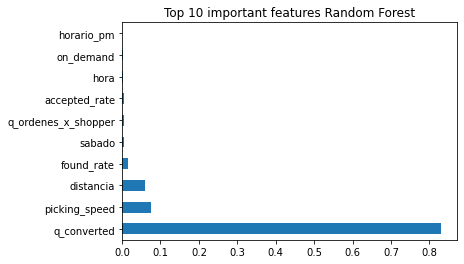

In [46]:
X = df[["on_demand","hora","sabado","q_converted"
     ,"found_rate","picking_speed","accepted_rate","q_ordenes_x_shopper","horario_pm","distancia"]]
feat_importances = pd.Series(rf1.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 10 important features Random Forest")
plt.show()

### 5.4 Modelo Gradient Boosting

In [47]:
# Adjust first model Gradient Boosted
gb=GradientBoostingRegressor()
gb1=gb.fit(x_train1, y_train)

# Predictions
gb_pred =gb1.predict(x_test1)

# Model errors

mae_gb = mean_absolute_error(y_test, gb_pred)
rmse_gb = np.sqrt(mean_squared_error(y_test, gb_pred))

print("MAE del modelo Grandient Boosting  es: ", mae_gb)
print("RMSE del modelo Grandient Boosting  es ", rmse_gb)

MAE del modelo Grandient Boosting  es:  18.7652852128389
RMSE del modelo Grandient Boosting  es  24.633075789743607


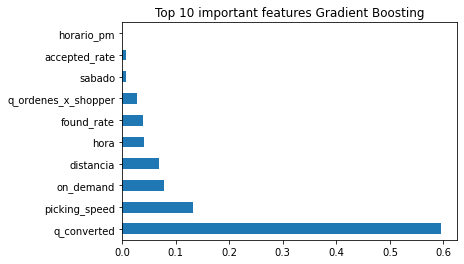

In [48]:
X = df[["on_demand","hora","sabado","q_converted"
     ,"found_rate","picking_speed","accepted_rate","q_ordenes_x_shopper","horario_pm","distancia"]]

feat_importances = pd.Series(gb1.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 10 important features Gradient Boosting")
plt.show()

### 5.5 Modelo Support Vector Machine

In [49]:
# Adjust first model Support Vector Machine
svr = SVR()
svr.fit(x_train1, y_train)

# Predictions
svr_pred=svr.predict(x_test1)

In [50]:
mae_svr = mean_absolute_error(y_test, svr_pred)
rmse_svr = np.sqrt(mean_squared_error(y_test, svr_pred))

In [51]:
print("MAE del modelo SVR : ", mae_svr)
print("RMSE del modelo SVR : ", rmse_svr)

MAE del modelo SVR :  19.362948126052334
RMSE del modelo SVR :  26.674080399285792


Se compararon 4 modelos predictivos, para ver cual de los modelos propuestos posee mejor desempeño de los resultados de los mismos, de los 4 algoritmos de Machine Learning evaluados el que tuvo menor **Error Absoluto Medio MAE** es el algoritmo correspondiente a **Gradient Boosted**  con un 18,76  comparados con los otros modelos que tuvieron un porcentaje mayor de error, el modelo que le sigue es el modelo de regresión lineal con un 19,19 y el subsiguiente es el modelo de Support Vector Machine con 19,36

## 6.- Exportacion de resultados (se incluye nueva variable de predicción)

Para calcular la predicción de **total_minutes** se utilizará el algoritmo de Gradient Boosted que fue el que tuvo el mejor desdempeño

In [52]:

#Predicciones usando la data de Test
predicciones_gb =gb1.predict(x_test1)

In [53]:
# Incorporacion de nueva columna 

prediction= pd.DataFrame((predicciones_gb),columns=['total_minutes_pred'])


In [54]:
#Adding real total minutes for comparation
predictions_df = pd.concat([x_test.reset_index()['order_id'],y_test.reset_index()['total_minutes'] , prediction.round() ], axis=1)

In [55]:
# Exporting dataframe to csv file
predictions_df.to_csv('input/data_prediction.csv', header=True, index=False)

## 7. Proximos pasos y recomendaciones

Con los antecendentes del estudio podemos visualizar algunos aspectos relevantes como por ejemplo las variables más predictoras son las que corresponden a Q_converted, picking speed y on demand y la distancia.

Seria importante en el futuro ccontar con variables como trafico, o si la tienda es nueva o nó, esto podria influir desde el punto de vista que para el shopper debaria tomar más tiempo si tiene que seleccionar productos de una tienda que ya conoce o no.

Con respecto a la ilustracion de imagenes georeferenciadas podriamos validar si existe un centro de distribución donde lleguen todos los shoppers a tomar pedidos entre las condes y providencia que es el eje donde se concentran la mayor cantidad tanto de solicitudes de clientes como tiendas donde compran los shoppers

Otra variable que se podria incluir si el producto solicitado por cliente es premium o no, porque generalmente cuando el producto es premium el shopper toma mas tiempo en encontrar su reemplazo
